<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu1/Minggu1_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython modlamp numpy pandas matplotlib seaborn scikit-learn #Packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.7/176.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 15.1 MB/s eta 0:00:00


Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# BioInformatic & Featured Tools
from Bio.SeqUtils.ProtParam import ProteinAnalysis # For calculate amino acid, hydrophobic, charge

# Ml preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit #For split dataset
from sklearn.preprocessing import StandardScaler # FOr normalization
from sklearn.svm import SVC # For model classifier
from sklearn.neural_network import MLPClassifier # For MLP Classifer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, confusion_matrix, RocCurveDisplay,
    ConfusionMatrixDisplay
) # For evaluate
from itertools import product # For extraction AAC


np.random.seed(42)
random.seed(42)

**EDA**

**Objective**
1. Load Dataset
2. Dataset Cleaning
3. Sequence length distribution & Class balance
4. Amino Acid Composition
5. Physicochemical Propoerties
6. k-mer Example

1. Load Dataset

In [ ]:
# Define variable for each path
pdb_path = "/content/PDB1063-186.csv"
uni_path = "/content/UniSwiss.csv"

# Define variable for read csv file into pandas dataframe
pdb_df = pd.read_csv("/kaggle/input/dataset/PDB1063-186.csv")
uni_df = pd.read_csv("/kaggle/input/dataset/UniSwiss.csv")

# Get dataset df/dataframe
print("PDB1063 shape:", pdb_df.shape)
print("UniSwiss shape:", uni_df.shape)

# Get dataset column name
print("\nPDB1063 columns:", pdb_df.columns.tolist())
print("UniSwiss columns:", uni_df.columns.tolist())

# Get top 3 dataframe for each dataset
print(pdb_df.head(3))
print(uni_df.head(3))



PDB1063 shape: (1249, 4)
UniSwiss shape: (9762, 4)

PDB1063 columns: ['identifier', 'sequence', 'label', 'set']
UniSwiss columns: ['identifier', 'sequence', 'label', 'set']
  identifier                                           sequence  label    set
0      1AKHB  TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...      1  train
1      1B6WA  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...      1  train
2      1C1KA  MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...      1  train
  identifier                                           sequence  label    set
0     P08956  MMNKSNFEFLKGVNDFTYAIACAAENNYPDDPNTTLIKMRMFGEAT...      1  train
1     P27235  MPPQRSRRRKRASATQLYQTCKASGTCPPDVIPKVEGTTLADKILQ...      1  train
2     P0AD01  MINVLIIDDDAMVAELNRRYVAQIPGFQCCGTASTLEKAKEIIFNS...      1  train


2. Dataset cleaning

In [ ]:
# Get information about the datasets
print("\nMissing Values in PDB Dataset:")
print(pdb_df.isnull().sum())
print("\nMissing Values in UniSwiss Dataset:")
print(uni_df.isnull().sum())

# Clean duplicates dataset
# Convert to uppercase and remove invalid amino acids
valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
def clean_sequence(seq):
    if not isinstance(seq, str):
        return ""
    seq = seq.strip().upper()
    return ''.join([a for a in seq if a in valid_aa])

pdb_df["sequence"] = pdb_df["sequence"].apply(clean_sequence)
uni_df["sequence"] = uni_df["sequence"].apply(clean_sequence)

# Get total sequence before clean
print("\nBefore duplicate cleaning:")
print(f"PDB total rows: {len(pdb_df)}, unique sequences: {pdb_df['sequence'].nunique()}")
print(f"UniSwiss total rows: {len(uni_df)}, unique sequences: {uni_df['sequence'].nunique()}")

# Drop duplicate sequence
pdb_df = pdb_df.drop_duplicates(subset=["sequence", "label"], keep="first").reset_index(drop=True)
uni_df = uni_df.drop_duplicates(subset=["sequence", "label"], keep="first").reset_index(drop=True)

pdb_df["seq_len"] = pdb_df["sequence"].str.len()
uni_df["seq_len"] = uni_df["sequence"].str.len()

pdb_df = pdb_df[pdb_df["seq_len"] > 0].dropna(subset=["sequence", "label"])
uni_df = uni_df[uni_df["seq_len"] > 0].dropna(subset=["sequence", "label"])

print(f"PDB1063 shape: {pdb_df.shape}")
print(f"UniSwiss shape: {uni_df.shape}")

print("\nUnique sequences after cleaning:")
print("Total Non-dups PDB:", pdb_df['sequence'].nunique())
print("Total Non-dups UniSwiss:", uni_df['sequence'].nunique())




Missing Values in PDB Dataset:
identifier    0
sequence      0
label         0
set           0
dtype: int64

Missing Values in UniSwiss Dataset:
identifier    0
sequence      0
label         0
set           0
dtype: int64

Before duplicate cleaning:
PDB total rows: 1249, unique sequences: 1171
UniSwiss total rows: 9762, unique sequences: 9696
PDB1063 shape: (1171, 5)
UniSwiss shape: (9697, 5)

Unique sequences after cleaning:
Total Non-dups PDB: 1171
Total Non-dups UniSwiss: 9696


3. Sequence length distribution & Class balance

Total PDB Sequence: 1171
Total Uniswiss Sequence: 9697

Average PDB Sequence Length: 243
Average Uniswiss Sequence Length: 478

Median PDB Sequence Length: 194.0
Median UniSwiss Sequence Length: 359.0

Std Dev PDB Sequence Length: 179.77
Std Dev UniSwiss Sequence Length: 462.66

Minimum PDB Sequence Length: 50
Maximum PDB Sequence Length: 1323

Minimum Uniswiss Sequence Length: 49
Maximum Uniswiss Sequence Length: 8515

Label Distribution in PDB Dataset:
label
0    638
1    533
Name: count, dtype: int64

Label Distribution in UniSwiss Dataset:
label
0    4880
1    4817
Name: count, dtype: int64


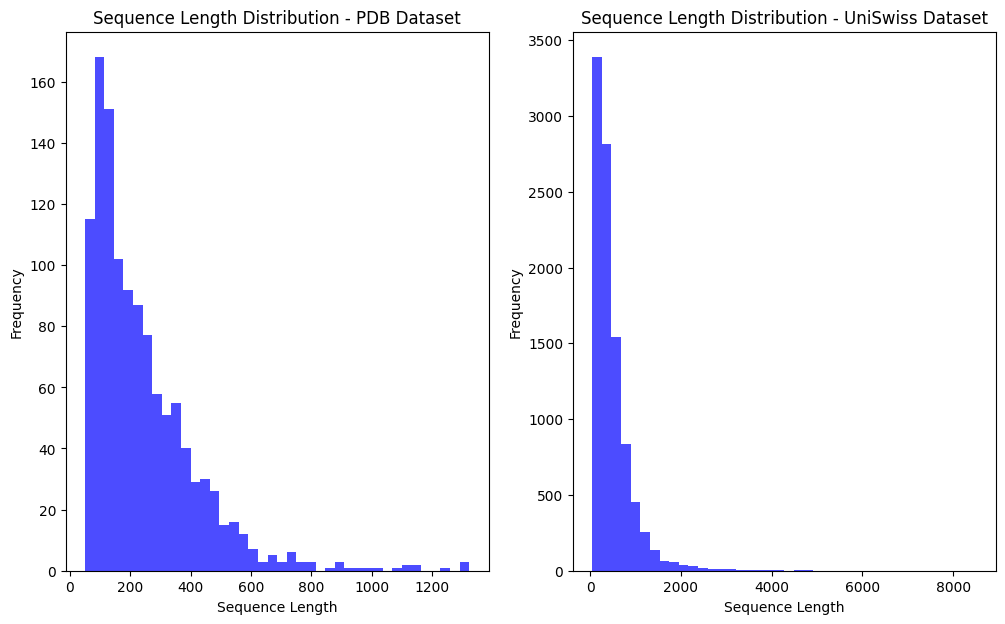

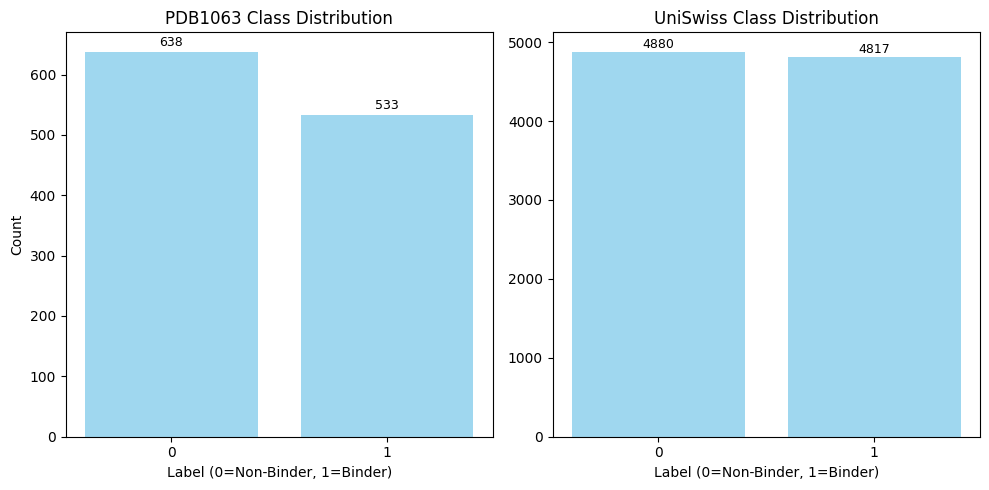

In [ ]:
# Count the label distribution balances
pdb_label_counts = pdb_df['label'].value_counts()
uni_label_counts = uni_df['label'].value_counts()

# Get sequence length detail for each dataset
print("Total PDB Sequence:", len(pdb_df))
print("Total Uniswiss Sequence:", len(uni_df))

print("\nAverage PDB Sequence Length:", int(pdb_df['seq_len'].mean()))
print("Average Uniswiss Sequence Length:", int(uni_df['seq_len'].mean()))

print("\nMedian PDB Sequence Length:", round(pdb_df['seq_len'].median(), 2))
print("Median UniSwiss Sequence Length:", round(uni_df['seq_len'].median(), 2))

print("\nStd Dev PDB Sequence Length:", round(pdb_df['seq_len'].std(), 2))
print("Std Dev UniSwiss Sequence Length:", round(uni_df['seq_len'].std(), 2))

print("\nMinimum PDB Sequence Length:", pdb_df['seq_len'].min())
print("Maximum PDB Sequence Length:", pdb_df['seq_len'].max())

print("\nMinimum Uniswiss Sequence Length:", uni_df['seq_len'].min())
print("Maximum Uniswiss Sequence Length:", uni_df['seq_len'].max())

print("\nLabel Distribution in PDB Dataset:")
print(pdb_label_counts)
print("\nLabel Distribution in UniSwiss Dataset:")
print(uni_label_counts)


# Visualize protein using histogram.
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.hist(pdb_df['seq_len'], bins=40, alpha=0.7, color='blue')
plt.title('Sequence Length Distribution - PDB Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(uni_df['seq_len'], bins=40, alpha=0.7, color='blue')
plt.title('Sequence Length Distribution - UniSwiss Dataset')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

# Counts total DNA binders (1) and non-binders (0) exist for both dataset.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pdb_counts_label = pdb_df['label'].value_counts().sort_index()
axes[0].bar(pdb_counts_label.index.astype(str), pdb_counts_label.values, color='skyblue', alpha=0.8)
axes[0].set_title("PDB1063 Class Distribution")
axes[0].set_xlabel("Label (0=Non-Binder, 1=Binder)")
axes[0].set_ylabel("Count")
for i, v in enumerate(pdb_counts_label.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontsize=9)

uni_counts_label = uni_df['label'].value_counts().sort_index()
axes[1].bar(uni_counts_label.index.astype(str), uni_counts_label.values, color='skyblue', alpha=0.8)
axes[1].set_title("UniSwiss Class Distribution")
axes[1].set_xlabel("Label (0=Non-Binder, 1=Binder)")
for i, v in enumerate(uni_counts_label.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

4. Amino Acid Composition

/usr/local/lib/python3.11/dist-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


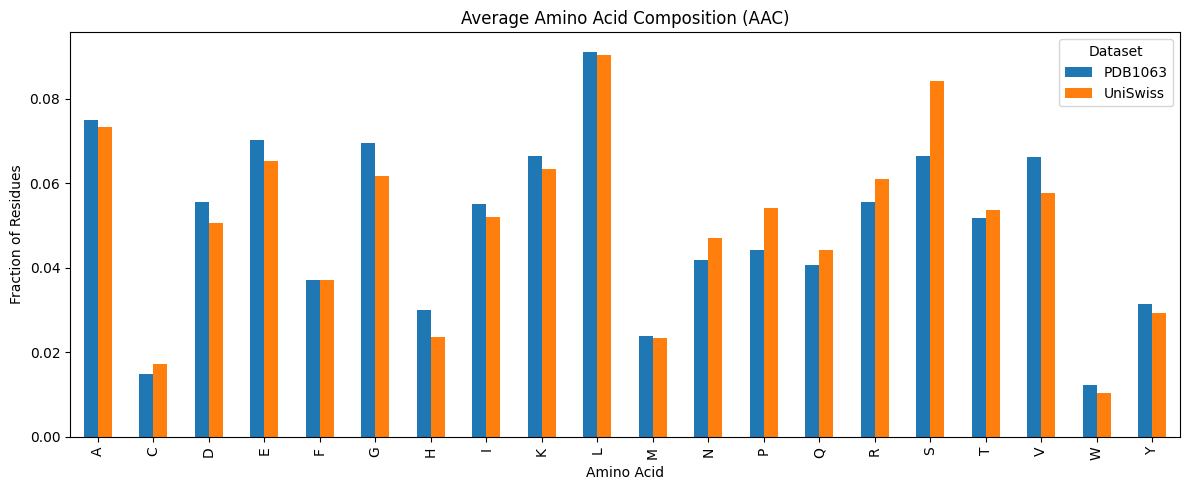

In [ ]:
# Function with ACC Composition method
def asam_amino_composition(seq):
    analysed_seq = ProteinAnalysis(seq)
    return analysed_seq.get_amino_acids_percent()

# Convert list of dicts to DataFrame, then take mean across all proteins.
pdb_aac_mean = pd.DataFrame(pdb_df["sequence"].apply(lambda s: asam_amino_composition(s)).tolist()).mean()
uni_aac_mean = pd.DataFrame(uni_df["sequence"].apply(lambda s: asam_amino_composition(s)).tolist()).mean()

# Visualize chart for both dataset.
aac_df = pd.DataFrame({"PDB1063": pdb_aac_mean, "UniSwiss": uni_aac_mean})
aac_df.plot(kind="bar", figsize=(12, 5))
plt.title("Average Amino Acid Composition (AAC)")
plt.ylabel("Fraction of Residues")
plt.xlabel("Amino Acid")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


5. Physicochemical Properties


Average physicochemical properties by class (PDB1063):
        avg_mw  avg_hydrophobicity  avg_charge
label                                         
0      111.175              -0.314      -0.015
1      113.079              -0.461       0.011

Average physicochemical properties by class (UniSwiss):
        avg_mw  avg_hydrophobicity  avg_charge
label                                         
0      111.614              -0.289       0.000
1      111.885              -0.599       0.017

 Average hydrophobicity (-0.388) → moderately balanced → possibly globular or amphipathic (surface-exposed + buried residues)
 Average charge (-0.002) → near neutral charge → electrostatically balanced proteins
------------------------------------------------------------

 Average hydrophobicity (-0.444) → moderately balanced → possibly globular or amphipathic (surface-exposed + buried residues)
 Average charge (0.009) → near neutral charge → electrostatically balanced proteins

 Pattern: hydrophilic yet 

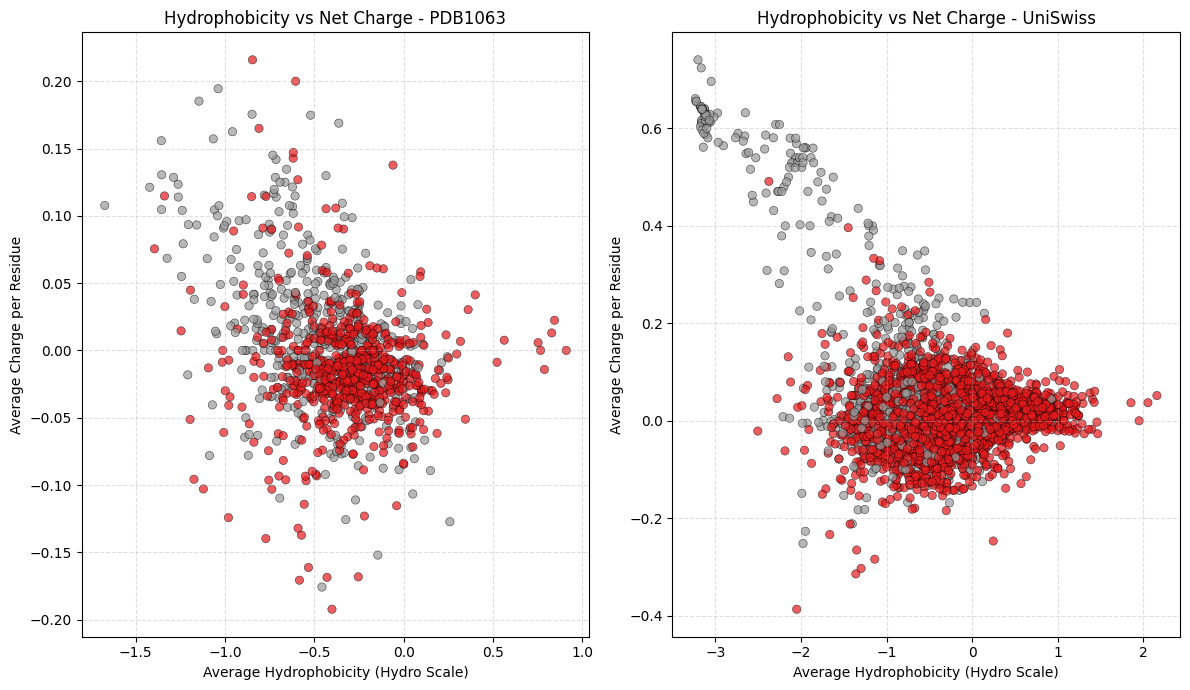

In [ ]:
# Function for physicochemical features
def physicochemical_properties(sequence):
    """
    Calculate physicochemical descriptors:
    - Average Molecular Weight
    - Average Hydrophobicity (GRAVY-like score)
    - Net Charge
    - Total Molecular Weight
    - Sequence Length
    Based on amino acid properties table from Tutorial 5 (Preprocessing Data Biologis).
    """
    # Amino acid properties from standard biochemistry tables
    aa_properties = {
        'A': {'mw': 71.04, 'hydro': 1.8, 'charge': 0},
        'C': {'mw': 103.01, 'hydro': 2.5, 'charge': 0},
        'D': {'mw': 115.03, 'hydro': -3.5, 'charge': -1},
        'E': {'mw': 129.04, 'hydro': -3.5, 'charge': -1},
        'F': {'mw': 147.07, 'hydro': 2.8, 'charge': 0},
        'G': {'mw': 57.02, 'hydro': -0.4, 'charge': 0},
        'H': {'mw': 137.06, 'hydro': -3.2, 'charge': 0},
        'I': {'mw': 113.08, 'hydro': 4.5, 'charge': 0},
        'K': {'mw': 128.09, 'hydro': -3.9, 'charge': 1},
        'L': {'mw': 113.08, 'hydro': 3.8, 'charge': 0},
        'M': {'mw': 131.04, 'hydro': 1.9, 'charge': 0},
        'N': {'mw': 114.04, 'hydro': -3.5, 'charge': 0},
        'P': {'mw': 97.05,  'hydro': -1.6, 'charge': 0},
        'Q': {'mw': 128.06, 'hydro': -3.5, 'charge': 0},
        'R': {'mw': 156.10, 'hydro': -4.5, 'charge': 1},
        'S': {'mw': 87.03,  'hydro': -0.8, 'charge': 0},
        'T': {'mw': 101.05, 'hydro': -0.7, 'charge': 0},
        'V': {'mw': 99.07,  'hydro': 4.2, 'charge': 0},
        'W': {'mw': 186.08, 'hydro': -0.9, 'charge': 0},
        'Y': {'mw': 163.06, 'hydro': -1.3, 'charge': 0}
    }
    # initialize total
    total_mw, total_hydro, total_charge, valid_aa_count = 0, 0, 0, 0

    # iterate throught the sequence
    for aa in sequence.upper():
        if aa in aa_properties:
            total_mw += aa_properties[aa]['mw']
            total_hydro += aa_properties[aa]['hydro']
            total_charge += aa_properties[aa]['charge']
            valid_aa_count += 1

    if valid_aa_count == 0:
        return np.nan, np.nan, np.nan

    avg_mw = total_mw / valid_aa_count
    avg_hydro = total_hydro / valid_aa_count
    avg_charge = total_charge / valid_aa_count

    return avg_mw, avg_hydro, avg_charge

# Define variable for each sequence to apply in both dataset
pdb_phys = pdb_df["sequence"].apply(lambda s: physicochemical_properties(s))
uni_phys = uni_df["sequence"].apply(lambda s: physicochemical_properties(s))

# Unpack descriptor into new colums
pdb_df["avg_mw"], pdb_df["avg_hydrophobicity"], pdb_df["avg_charge"] = zip(*pdb_phys)
uni_df["avg_mw"], uni_df["avg_hydrophobicity"], uni_df["avg_charge"] = zip(*uni_phys)

#Classwise statistics
pdb_stats = pdb_df.groupby("label")[["avg_mw","avg_hydrophobicity","avg_charge"]].mean().round(3)
uni_stats = uni_df.groupby("label")[["avg_mw","avg_hydrophobicity","avg_charge"]].mean().round(3)

def interpret_physicochemical_summary(stats_df, dataset_name):
    # Charge and Hydrophobic analyse
    mean_hydro = stats_df["avg_hydrophobicity"].mean()
    mean_charge = stats_df["avg_charge"].mean()

    # Hydrophobic
    if mean_hydro > 0.5:
        hydro_desc = "strongly hydrophobic → likely membrane-associated or transmembrane proteins"
    elif -0.5 <= mean_hydro <= 0.5:
        hydro_desc = "moderately balanced → possibly globular or amphipathic (surface-exposed + buried residues)"
    else:
        hydro_desc = "strongly hydrophilic → likely soluble, cytoplasmic or DNA-binding proteins"

    # net charge
    if mean_charge > 0.1:
        charge_desc = "overall positively charged → may interact with negatively charged molecules (like DNA)"
    elif mean_charge < -0.1:
        charge_desc = "overall negatively charged → possible acidic or extracellular domains"
    else:
        charge_desc = "near neutral charge → electrostatically balanced proteins"

    print(f"\n Average hydrophobicity ({mean_hydro:.3f}) → {hydro_desc}")
    print(f" Average charge ({mean_charge:.3f}) → {charge_desc}")

    if mean_hydro < 0 and mean_charge > 0:
        print("\n Pattern: hydrophilic yet positively charged → commonly found in DNA/RNA-binding proteins.")
    elif mean_hydro > 0.5 and abs(mean_charge) < 0.1:
        print("\n Pattern: neutral but hydrophobic → typical of membrane-anchored or transmembrane proteins.")
    elif abs(mean_hydro) < 0.3 and abs(mean_charge) < 0.05:
        print("\n Pattern: balanced composition → may correspond to cytosolic enzymes or structural proteins.")
    print("-" * 60)

print("\nAverage physicochemical properties by class (PDB1063):")
print(pdb_stats)
print("\nAverage physicochemical properties by class (UniSwiss):")
print(uni_stats)

# Visualize Hydrophobicity vs Charge
plt.figure(figsize=(12,7))
plt.subplot(1, 2, 1)
plt.scatter(
    pdb_df["avg_hydrophobicity"],
    pdb_df["avg_charge"],
    c=pdb_df["label"],
    cmap="Set1",
    alpha=0.7,
    edgecolor="k",
    linewidth=0.4
)
plt.title("Hydrophobicity vs Net Charge - PDB1063")
plt.xlabel("Average Hydrophobicity (Hydro Scale)")
plt.ylabel("Average Charge per Residue")
plt.grid(True, linestyle="--", alpha=0.4)

plt.subplot(1, 2, 2)
plt.scatter(
    uni_df["avg_hydrophobicity"],
    uni_df["avg_charge"],
    c=uni_df["label"],
    cmap="Set1",
    alpha=0.7,
    edgecolor="k",
    linewidth=0.4
)
plt.title("Hydrophobicity vs Net Charge - UniSwiss")
plt.xlabel("Average Hydrophobicity (Hydro Scale)")
plt.ylabel("Average Charge per Residue")
plt.grid(True, linestyle="--", alpha=0.4)

interpret_physicochemical_summary(pdb_stats, "PDB1063")
interpret_physicochemical_summary(uni_stats, "UniSwiss")
plt.tight_layout()
plt.show()


**Features Extraction**

**Objective**
1. AAC
2. DPC
3. Apply AAC & DPC
4. Convert into dataframes
5. Combine Feat + Lables


1. AAC

In [ ]:
#Function to compute AAC
def AAC(seq):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    seq = seq.upper()
    length = len(seq)
    counts = {aa: 0 for aa in amino_acids}

    # Count occurrences of each amino acid
    for aa in seq:
        if aa in counts:
            counts[aa] += 1

    # Normalize by sequence length to get frequencies
    if length > 0:
        for aa in counts:
            counts[aa] /= length
    else:
        for aa in counts:
            counts[aa] = 0.0

    return counts


2. DPC

In [ ]:
def DPC(seq):
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    dipeptides = ["".join(p) for p in product(amino_acids, repeat=2)]  # All 400 pairs

    counts = {dp: 0 for dp in dipeptides}
    seq = seq.upper()

    # Count dipeptides
    for i in range(len(seq) - 1):
        dp = seq[i:i+2]
        if dp in counts:
            counts[dp] += 1

    total = sum(counts.values())

    # Normalize counts
    if total > 0:
        for dp in counts:
            counts[dp] /= total
    else:
        for dp in counts:
            counts[dp] = 0.0

    return counts

3. Apply DPC and AAC Extraction

In [ ]:
print("Applying AAC and DPC features for PDB1063...")
pdb_aac = pdb_df["sequence"].apply(lambda s: AAC(s))
pdb_dpc = pdb_df["sequence"].apply(lambda s: DPC(s))

print("Applying AAC and DPC features for UniSwiss...")
uni_aac = uni_df["sequence"].apply(lambda s: AAC(s))
uni_dpc = uni_df["sequence"].apply(lambda s: DPC(s))

print("Feature extraction completed.")

Applying AAC and DPC features for PDB1063...
Applying AAC and DPC features for UniSwiss...
Feature extraction completed.


4. Convert into DataFrames

In [ ]:
pdb_aac_df = pd.DataFrame(list(pdb_aac))
pdb_dpc_df = pd.DataFrame(list(pdb_dpc))
uni_aac_df = pd.DataFrame(list(uni_aac))
uni_dpc_df = pd.DataFrame(list(uni_dpc))

# Get shape for each dataset
print("AAC shape (PDB):", pdb_aac_df.shape)
print("DPC shape (PDB):", pdb_dpc_df.shape)
print("AAC shape (UniSwiss):", uni_aac_df.shape)
print("DPC shape (UniSwiss):", uni_dpc_df.shape)

AAC shape (PDB): (1171, 20)
DPC shape (PDB): (1171, 400)
AAC shape (UniSwiss): (9697, 20)
DPC shape (UniSwiss): (9697, 400)


5. Combine Feat + Labs

In [ ]:
# Merge AAC, DPC, and physicochemical descriptors
pdb_features = pd.concat(
    [pdb_aac_df, pdb_dpc_df, pdb_df[["avg_mw", "avg_hydrophobicity", "avg_charge"]].reset_index(drop=True)],
    axis=1
)

uni_features = pd.concat(
    [uni_aac_df, uni_dpc_df, uni_df[["avg_mw", "avg_hydrophobicity", "avg_charge"]].reset_index(drop=True)],
    axis=1
)

# Extract label vectors
pdb_labels = pdb_df["label"].values
uni_labels = uni_df["label"].values

print("\nFinal feature matrix shapes:")
print("PDB1063:", pdb_features.shape)
print("UniSwiss:", uni_features.shape)


Final feature matrix shapes:
PDB1063: (1171, 423)
UniSwiss: (9697, 423)


**Pre-Process**

**Objective**
1. Split Dataset
2. Scaling


1. Split Dataset

In [ ]:
# Count total set distribution for split
pdb_set_counts = pdb_df['set'].value_counts()
pdb_set_percentage = (pdb_set_counts / len(pdb_df)) * 100 #Calculate into percentage
uni_set_counts = uni_df['set'].value_counts()
uni_set_percentage = (uni_set_counts / len(uni_df)) * 100 #Calculate into percentage

print("\nRaw PDB Dataset split:")
print(pdb_set_counts)
print(pdb_set_percentage)

print("\nRaw UniSwiss Dataset Split:")
print(uni_set_counts)
print(uni_set_percentage)

RANDOM_SEED = 42
def split_dataset(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=RANDOM_SEED):
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_size + test_size), random_state=random_state)
    for train_idx, temp_idx in sss1.split(X, y):
        X_train, X_temp = X.iloc[train_idx], X.iloc[temp_idx]
        y_train, y_temp = y[train_idx], y[temp_idx]

    # Split temp into validation and test (equal parts of remaining)
    relative_test_size = test_size / (val_size + test_size)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=relative_test_size, random_state=random_state)
    for val_idx, test_idx in sss2.split(X_temp, y_temp):
        X_val, X_test = X_temp.iloc[val_idx], X_temp.iloc[test_idx]
        y_val, y_test = y_temp[val_idx], y_temp[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test


# --- Apply the split for PDB dataset ---
X_train_pdb, X_val_pdb, X_test_pdb, y_train_pdb, y_val_pdb, y_test_pdb = split_dataset(pdb_features, pdb_labels)

# --- Apply the split for UniSwiss dataset ---
X_train_uni, X_val_uni, X_test_uni, y_train_uni, y_val_uni, y_test_uni = split_dataset(uni_features, uni_labels)

# --- Print data shapes to confirm successful split ---
print("\nPDB1063 splits:")
print(" Train:", X_train_pdb.shape, "| Val:", X_val_pdb.shape, "| Test:", X_test_pdb.shape)
print("UniSwiss splits:")
print(" Train:", X_train_uni.shape, "| Val:", X_val_uni.shape, "| Test:", X_test_uni.shape)



Raw PDB Dataset split:
set
train    1060
test      111
Name: count, dtype: int64
set
train    90.520922
test      9.479078
Name: count, dtype: float64

Raw UniSwiss Dataset Split:
set
train    8941
test      756
Name: count, dtype: int64
set
train    92.203774
test      7.796226
Name: count, dtype: float64

PDB1063 splits:
 Train: (936, 423) | Val: (117, 423) | Test: (118, 423)
UniSwiss splits:
 Train: (7757, 423) | Val: (970, 423) | Test: (970, 423)


2. Scaling/normalize

In [ ]:
# Define variable for each dataset
scaler_pdb = StandardScaler()
scaler_uni = StandardScaler()

# Fit on training data only, then transform all splits
X_train_pdb_scaled = scaler_pdb.fit_transform(X_train_pdb)
X_val_pdb_scaled   = scaler_pdb.transform(X_val_pdb)
X_test_pdb_scaled  = scaler_pdb.transform(X_test_pdb)

X_train_uni_scaled = scaler_uni.fit_transform(X_train_uni)
X_val_uni_scaled   = scaler_uni.transform(X_val_uni)
X_test_uni_scaled  = scaler_uni.transform(X_test_uni)

#Get confirmation of scaling
print("Feature scaling completed.")
print("Example: mean of PDB train (after scaling):", np.mean(X_train_pdb_scaled), "| std:", np.std(X_train_pdb_scaled))

Feature scaling completed.
Example: mean of PDB train (after scaling): 1.1436255035337835e-17 | std: 1.0


**Model Training (Baseline)**

**Objective**
1. Setup function
2. Set HyperParameter + Train
3. Summary Result


1. Setup function

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, dataset_name):
    print(f"\nTraining {model.__class__.__name__} on {dataset_name} dataset...")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    duration = end - start

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute evaluation metrics
    acc  = accuracy_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    mcc  = matthews_corrcoef(y_val, y_pred)
    auc  = roc_auc_score(y_val, y_prob) if y_prob is not None else np.nan

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f" Done in {duration:.2f}s | Val Accuracy: {acc:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    return {
        "Model": model.__class__.__name__,
        "Dataset": dataset_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1": f1,
        "MCC": mcc,
        "ROC_AUC": auc,
        "Train_Time(s)": duration
    }

2. SVM

In [ ]:
# Define baseline SVM hyperparameters
svm_params = dict(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)

# Initialize SVM models for both datasets
svm_pdb = SVC(**svm_params)
svm_uni = SVC(**svm_params)

#Train & evaluate
svm_pdb_result = evaluate_model(svm_pdb, X_train_pdb_scaled, y_train_pdb, X_val_pdb_scaled, y_val_pdb, "PDB1063")
svm_uni_result = evaluate_model(svm_uni, X_train_uni_scaled, y_train_uni, X_val_uni_scaled, y_val_uni, "UniSwiss")


Training SVC on PDB1063 dataset...
 Done in 1.03s | Val Accuracy: 0.735 | F1: 0.721 | AUC: 0.808

Training SVC on UniSwiss dataset...
 Done in 70.19s | Val Accuracy: 0.719 | F1: 0.708 | AUC: 0.799


3. Summary Result

In [ ]:
#Model summary
results_df = pd.DataFrame([svm_pdb_result, svm_uni_result]) #Change the params with your trained model
display(results_df)

,Model,Dataset,Accuracy,Precision,Recall,Specificity,F1,MCC,ROC_AUC,Train_Time(s)
0,SVC,PDB1063,0.735043,0.689655,0.754717,0.71875,0.720721,0.471387,0.807783,1.02914
1,SVC,UniSwiss,0.718557,0.730684,0.686722,0.75000,0.708021,0.437667,0.799140,70.19317


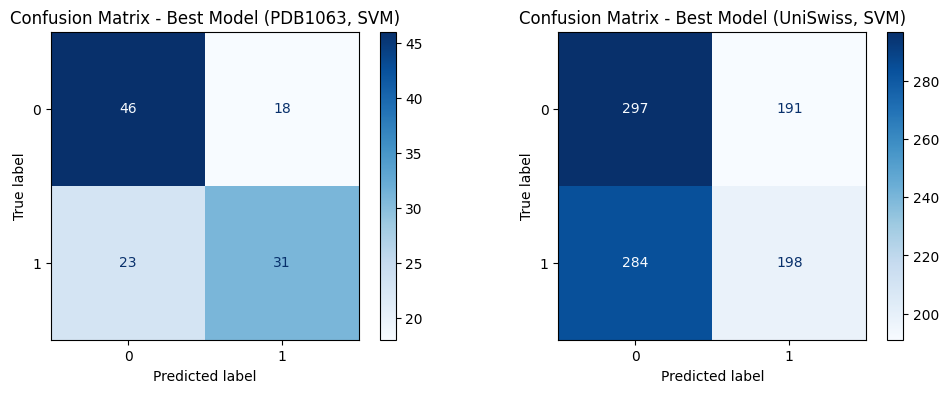

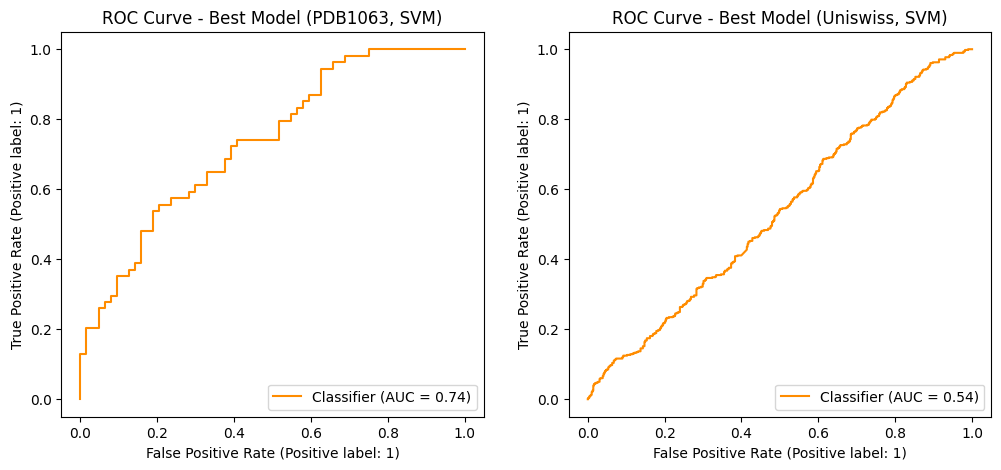

In [ ]:
# Define model for Visualize
best_model = svm_pdb  # change to svm_pdb or svm_uni as needed depend on your model
X_test, y_test = X_test_pdb_scaled, y_test_pdb  # change to X_test_uni_scaled, y_test_uni

best_model2 = svm_uni  # change to svm_pdb, mlp_uni, or svm_uni as needed
X_test_2, y_test_2 = X_test_uni_scaled, y_test_uni  # change to X_test_uni_scaled, y_test_uni

# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

y_pred_2 = best_model.predict(X_test_2)
y_prob_2 = best_model.predict_proba(X_test_2)[:, 1]

# Confusion matrix for both dataset
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix - Best Model (PDB1063, SVM)") # Change model name

plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_predictions(y_test_2, y_pred_2, cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix - Best Model (UniSwiss, SVM)") # Change model name

# ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, y_prob, color="darkorange", ax=plt.gca())
plt.title("ROC Curve - Best Model (PDB1063, SVM)") # Change model name

plt.subplot(1, 2, 2)
RocCurveDisplay.from_predictions(y_test_2, y_prob_2, color="darkorange", ax=plt.gca())
plt.title("ROC Curve - Best Model (Uniswiss, SVM)") # Change model name
plt.show()


CNN 1D

In [ ]:
!pip install biopython tensorflow -q

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from Bio import SeqIO


2025-11-02 15:35:11.406198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762097711.593418      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762097711.644626      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
df_pdb = pd.read_csv("/kaggle/input/dataset/PDB1063-186.csv")
df_uni = pd.read_csv("/kaggle/input/dataset/UniSwiss.csv")

print(df_pdb.head())
print(df_uni.head())


  identifier                                           sequence  label    set
0      1AKHB  TKPYRGHRFTKENVRILESWFAKNIENPYLDTKGLENLMKNTSLSR...      1  train
1      1B6WA  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...      1  train
2      1C1KA  MIKLRMPAGGERYIDGKSVYKLYLMIKQHMNGKYDVIKYNWCMRVS...      1  train
3      1C6VX  QQSKNSKFKNFRVYYREGRDQLWKGPGELLWKGEGAVLLKVGTDIK...      1  train
4      1C6VD  IHGQVNSDLGTWQMDCTHLEGKIVIVAVHVASGFIEAEVIPQETGR...      1  train
   identifier                                           sequence  label    set
0      P08956  MMNKSNFEFLKGVNDFTYAIACAAENNYPDDPNTTLIKMRMFGEAT...      1  train
1      P27235  MPPQRSRRRKRASATQLYQTCKASGTCPPDVIPKVEGTTLADKILQ...      1  train
2      P0AD01  MINVLIIDDDAMVAELNRRYVAQIPGFQCCGTASTLEKAKEIIFNS...      1  train
3  A0A024B7I0  MAYMCADSGNLMAIAQQVIKQKQQQEQQQQQSHHPQQQFLGLNPFS...      1  train
4      F4I443  MAEFTNMLMNPWVLHLQKLELELKCPLCLKLLNRPVLLPCDHVFCD...      1  train


In [ ]:
def prepare_data(df):
    y = pd.factorize(df['label'])[0]

    X_train, X_test, y_train, y_test = train_test_split(
        df['sequence'], y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test


In [ ]:
AA = "ACDEFGHIKLMNPQRSTVWY"
aa2idx = {aa:i for i, aa in enumerate(AA)}

def one_hot_encode(seq, max_len):
    seq = seq.upper()
    mat = np.zeros((max_len, len(AA)))
    for i, aa in enumerate(seq[:max_len]):
        if aa in aa2idx:
            mat[i, aa2idx[aa]] = 1
    return mat


In [ ]:
def build_cnn(max_len, num_classes):
    model = models.Sequential([
        layers.Input(shape=(max_len, len(AA))),
        layers.Conv1D(128, kernel_size=7, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Conv1D(256, kernel_size=5, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
def train_and_eval_cnn(name, df, max_len):
    print(f"\n==============================")
    print(f" Training CNN-1D on {name}")
    print(f"==============================")

    # split same as SVM
    X_train, X_test, y_train, y_test = prepare_data(df)

    # one-hot transform
    X_train_enc = np.array([one_hot_encode(seq, max_len) for seq in X_train])
    X_test_enc  = np.array([one_hot_encode(seq, max_len) for seq in X_test])

    model = build_cnn(max_len, len(np.unique(y_train)))

    history = model.fit(
        X_train_enc, y_train,
        validation_split=0.2,
        epochs=25,
        batch_size=64,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )

    # ---- PREDICTION ----
    y_proba = model.predict(X_test_enc)

    # If binary sigmoid → convert to class prediction
    if y_proba.shape[1] == 1:
        y_pred = (y_proba >= 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(y_proba, axis=1)



    # ---- METRICS ----
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Specificity (macro avg)
    cm = confusion_matrix(y_test, y_pred)
    tn = []; fp = []
    for i in range(len(cm)):
        tn_i = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp_i = np.sum(np.delete(cm, i, axis=0)[:, i])
        tn.append(tn_i); fp.append(fp_i)
    specificity = np.mean([ tn[i] / (tn[i] + fp[i] + 1e-9) for i in range(len(tn)) ])

    # ---- ROC-AUC ----
    try:
        # Softmax binary (2 probabilities)
        if y_proba.shape[1] == 2:
            roc_auc = roc_auc_score(y_test, y_proba[:,1])
        else:
            # Softmax multi-class
            roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
    except:
        roc_auc = np.nan

    # save for plotting later
    global y_test_pdb, y_pred_pdb, y_proba_pdb, y_test_uni, y_pred_uni, y_proba_uni
    if name == "PDB1063":
        y_test_pdb, y_pred_pdb, y_proba_pdb = y_test, y_pred, y_proba
    elif name == "UniSwiss":
        y_test_uni, y_pred_uni, y_proba_uni = y_test, y_pred, y_proba

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1-Score": f1,
        "MCC": mcc,
        "ROC-AUC": roc_auc
    }


In [ ]:
results = {}

results["PDB1063"] = train_and_eval_cnn("PDB1063", df_pdb, max_len=512)
results["UniSwiss"] = train_and_eval_cnn("UniSwiss", df_uni, max_len=900)




 Training CNN-1D on PDB1063


I0000 00:00:1762097723.838062      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762097723.838803      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/25


I0000 00:00:1762097728.846867      78 service.cc:148] XLA service 0x7c93c4033970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762097728.847455      78 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762097728.847493      78 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762097729.239115      78 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6454 - loss: 0.7042

I0000 00:00:1762097733.469408      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 445ms/step - accuracy: 0.6170 - loss: 0.7132 - val_accuracy: 0.6350 - val_loss: 0.6819
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6768 - loss: 0.6197 - val_accuracy: 0.6750 - val_loss: 0.6841
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7017 - loss: 0.6069 - val_accuracy: 0.5800 - val_loss: 0.6831
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6887 - loss: 0.5790 - val_accuracy: 0.5800 - val_loss: 0.6783
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7258 - loss: 0.5280 - val_accuracy: 0.5100 - val_loss: 0.6871
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7606 - loss: 0.5204 - val_accuracy: 0.4900 - val_loss: 0.6943
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7842 - loss: 0.4807 - val_accuracy: 0.4850 - val_loss: 0.7045
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7603 - loss: 0.5149 - val_accuracy: 0.4850 - val_loss: 

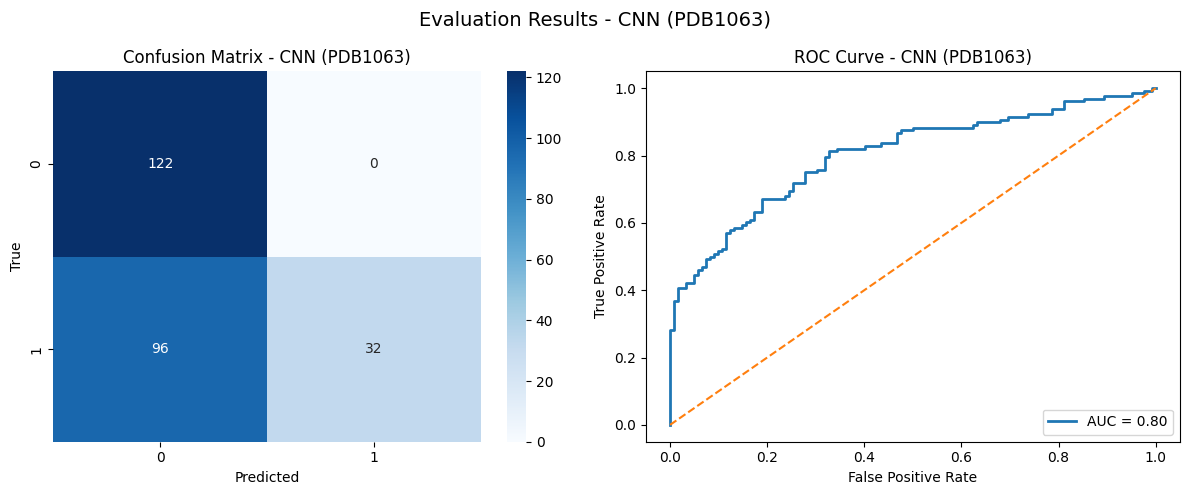

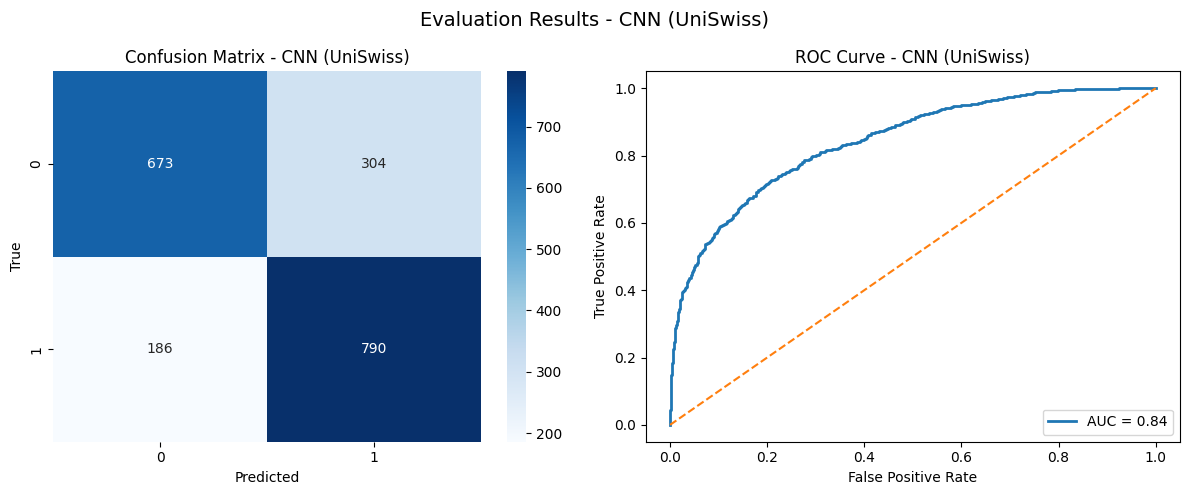

In [ ]:
def plot_cnn_results(title, y_test, y_pred, y_proba):
    from sklearn.metrics import roc_curve, auc, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12,5))

    # Confusion Matrix
    plt.subplot(1,2,1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - CNN ({title})")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # ROC Curve
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC Curve - CNN ({title})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

    plt.suptitle(f"Evaluation Results - CNN ({title})", fontsize=14)
    plt.tight_layout()
    plt.show()


# ==== CALL FOR BOTH DATASETS ====

plot_cnn_results("PDB1063", y_test_pdb, y_pred_pdb, y_proba_pdb)
plot_cnn_results("UniSwiss", y_test_uni, y_pred_uni, y_proba_uni)


In [ ]:
# === CNN RESULTS SUMMARY TABLE === #

cnn_results_df = pd.DataFrame([
    {   "Dataset": "PDB1063",
        "Model": "CNN-1D",
        **results["PDB1063"]
    },
    {   "Dataset": "UniSwiss",
        "Model": "CNN-1D",
        **results["UniSwiss"]
    }
])

display(cnn_results_df)


,Dataset,Model,Accuracy,Precision,Recall,Specificity,F1-Score,MCC,ROC-AUC
0,PDB1063,CNN-1D,0.616000,0.785101,0.616000,0.625000,0.555012,0.374043,0.802638
1,UniSwiss,CNN-1D,0.749104,0.752811,0.749104,0.749135,0.748193,0.501916,0.842433
